a) Summary Statistics & Missing-Value Report 

In [1]:
# Load data & initial checks
import pandas as pd
df = pd.read_csv("../data/benin-malanville.csv") 
df.info() # This prints a summary of the DataFrame’s structure

"""
open the CSV, inspect dtypes and rows to understand structure (timestamps, numeric columns, cleaning flags, sensors, wind columns, RH, BP, etc.).
"""


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

'\nopen the CSV, inspect dtypes and rows to understand structure (timestamps, numeric columns, cleaning flags, sensors, wind columns, RH, BP, etc.).\n'

In [3]:
# Numeric summary: it gives mean, std, min/max, quartiles ... quick numeric summary. 
num_summary = df.describe(include='number').T 
num_summary



,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,240.559452,331.131327,-12.9,-2.0,1.8,483.4,1413.0
DNI,525600.0,167.187516,261.710501,-7.8,-0.5,-0.1,314.2,952.3
DHI,525600.0,115.358961,158.691074,-12.6,-2.1,1.6,216.3,759.2
ModA,525600.0,236.589496,326.894859,0.0,0.0,4.5,463.7,1342.3
ModB,525600.0,228.883576,316.536515,0.0,0.0,4.3,447.9,1342.3
Tamb,525600.0,28.179683,5.924297,11.0,24.2,28.0,32.3,43.8
RH,525600.0,54.487969,28.073069,2.1,28.8,55.1,80.1,100.0
WS,525600.0,2.121113,1.603466,0.0,1.0,1.9,3.1,19.5
WSgust,525600.0,2.809195,2.029120,0.0,1.3,2.6,4.1,26.6
WSstdev,525600.0,0.473390,0.273395,0.0,0.4,0.5,0.6,4.2


In [4]:
# Missing values: shows how many missing values per column. 
# df.isna() - returns a DataFrame of booleans (True where the value is missing, False otherwise). 
# df.isna().sum() - For each column, counts how many True values there are (i.e., how many are missing). results a Series showing the count of missing values per column. 
missing_counts = df.isna().sum() 
missing_perc = (df.isna().mean() * 100).round(2) 
missing = pd.concat([missing_counts, missing_perc], axis=1) 
missing.columns = ['missing_count', 'missing_%'] 
missing

,missing_count,missing_%
Timestamp,0,0.0
GHI,0,0.0
DNI,0,0.0
DHI,0,0.0
ModA,0,0.0
ModB,0,0.0
Tamb,0,0.0
RH,0,0.0
WS,0,0.0
WSgust,0,0.0


In [5]:
# Flag columns with >5% nulls and list them
cols_over_5pct = missing[missing['missing_%'] > 5].index.tolist()
cols_over_5pct

['Comments']

b) Outlier Detection & Basic Cleaning

In [6]:
# flags rows as outliers if any selected column has a z-score greater than 3. 
import numpy as np 
from scipy import stats

cols = ["GHI","DNI","DHI","ModA","ModB","WS","WSgust"]
# safe zscore that ignores nan
z = np.abs(stats.zscore(df[cols], nan_policy='omit'))
z_df = pd.DataFrame(z, columns=cols, index=df.index)
df['outlier_any'] = (z_df > 3).any(axis=1)

# how many outliers
df['outlier_any'].sum(), len(df)

# quick inspect
df[df['outlier_any']].head(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,outlier_any
670,2021-08-09 11:11,836.0,235.0,610.6,778.8,783.8,30.3,68.2,3.2,4.1,0.7,190.5,18.4,999,0,0.0,63.0,52.7,NaN,True
671,2021-08-09 11:12,1274.0,698.8,615.2,1210.3,1210.3,30.1,69.6,3.4,4.1,0.6,175.8,13.3,999,0,0.0,63.7,53.1,NaN,True
672,2021-08-09 11:13,938.0,340.1,612.8,891.1,891.1,30.4,68.4,3.4,4.6,0.9,171.5,11.9,999,0,0.0,65.8,54.3,NaN,True
673,2021-08-09 11:14,718.5,126.8,593.2,682.6,682.6,30.6,68.2,4.7,5.6,0.6,160.7,8.0,999,0,0.0,65.4,54.2,NaN,True
674,2021-08-09 11:15,1349.0,771.8,618.0,1281.5,1281.5,30.9,67.1,4.0,4.6,0.4,169.1,12.3,999,0,0.0,65.0,53.5,NaN,True
675,2021-08-09 11:16,792.6,169.5,625.4,753.0,753.0,31.1,66.7,3.6,4.4,0.5,175.5,18.9,999,0,0.0,65.8,53.6,NaN,True
676,2021-08-09 11:17,1334.0,751.9,620.0,1267.3,1267.3,31.1,67.0,2.7,3.6,0.6,208.0,15.9,999,0,0.0,66.0,53.9,NaN,True
677,2021-08-09 11:18,943.0,351.5,602.8,846.0,850.0,31.0,67.9,3.1,4.1,0.6,181.0,8.9,999,0,0.0,67.8,55.1,NaN,True
717,2021-08-09 11:58,758.9,149.2,601.2,709.9,713.8,30.1,69.2,3.1,3.9,0.6,207.8,19.5,999,0,0.0,55.6,47.9,NaN,True
718,2021-08-09 11:59,632.8,23.0,603.3,587.0,591.0,30.2,69.3,3.0,4.1,0.7,211.1,22.6,999,0,0.0,56.4,48.4,NaN,True


In [7]:
# Impute median for missing / questionable values
for c in cols:
    median = df[c].median(skipna=True)
    df[c] = df[c].fillna(median)     # impute missing with median

In [8]:
# Remove obviously incorrect values (example: negative solar irradiance)

df = df[df['GHI'] >= 0]   # drop negative GHI rows if they are impossible

In [9]:
# Export cleaned CSV locally

df.to_csv("../data/benin_clean.csv", index=False)

c) Time Series Analysis

In [10]:
# Ensure Timestamp is datetime and set as index
# If Timestamp is still a column, convert to datetime
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df = df.dropna(subset=['Timestamp'])  # remove rows with invalid timestamps
    df = df.set_index('Timestamp')        # set as index
else:
    # Already index, ensure it's datetime
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df.dropna()  # drop any rows where conversion failed

# Sort by time
df = df.sort_index()

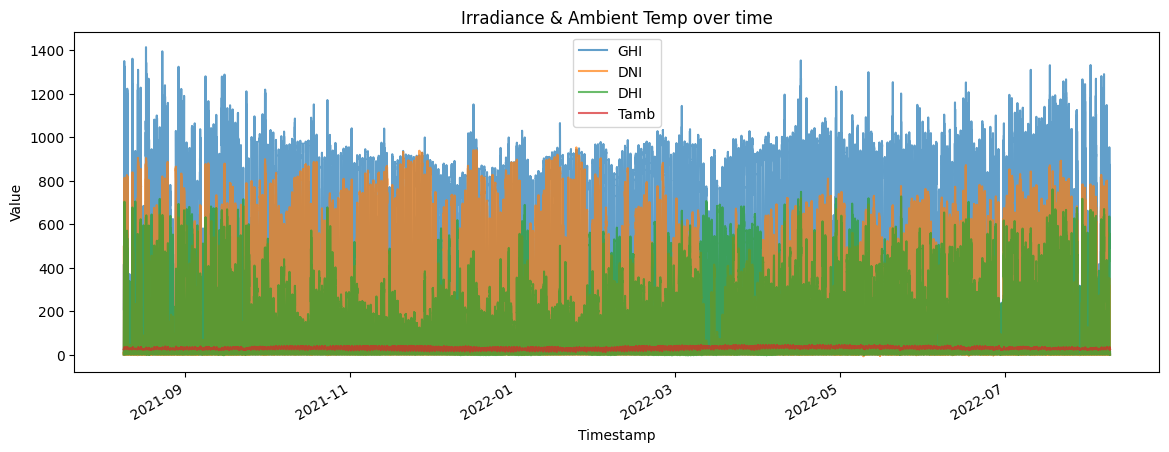

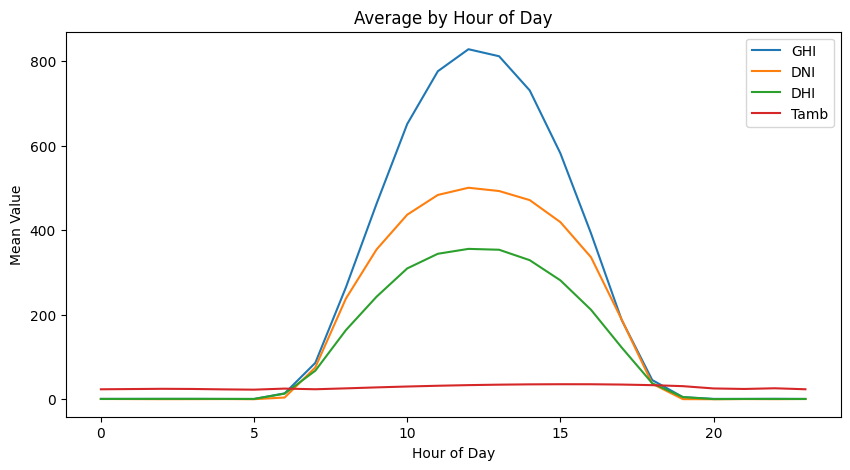

C:\Users\Admin\AppData\Local\Temp\ipykernel_796\3160582229.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[['GHI','DNI','DHI']].resample('M').mean()


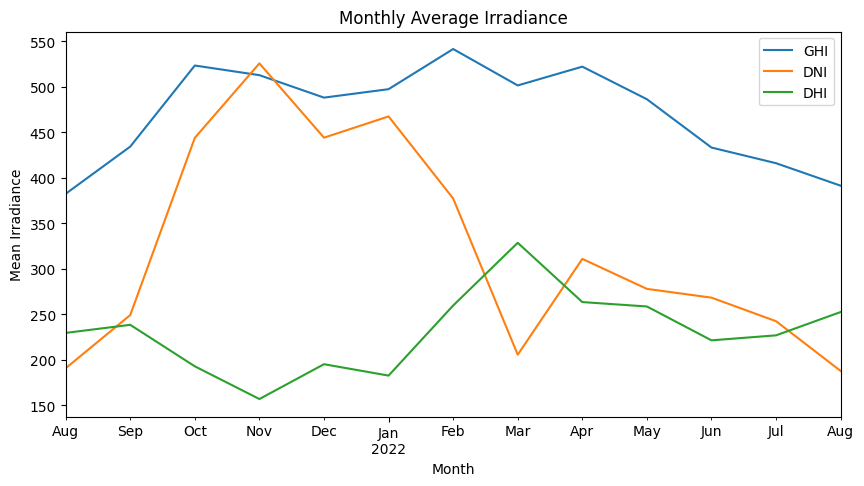

In [11]:
# Plots 
import matplotlib.pyplot as plt

# Plot GHI, DNI, DHI, Tamb over time
df[['GHI','DNI','DHI','Tamb']].plot(figsize=(14,5), alpha=0.7)
plt.title('Irradiance & Ambient Temp over time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

# Average by hour of day
hourly = df[['GHI','DNI','DHI','Tamb']].groupby(df.index.hour).mean()
hourly.plot(figsize=(10,5))
plt.title('Average by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Value')
plt.show()

# Monthly trends for irradiance
monthly = df[['GHI','DNI','DHI']].resample('M').mean()
monthly.plot(figsize=(10,5))
plt.title('Monthly Average Irradiance')
plt.xlabel('Month')
plt.ylabel('Mean Irradiance')
plt.show()


d) Cleaning Impact

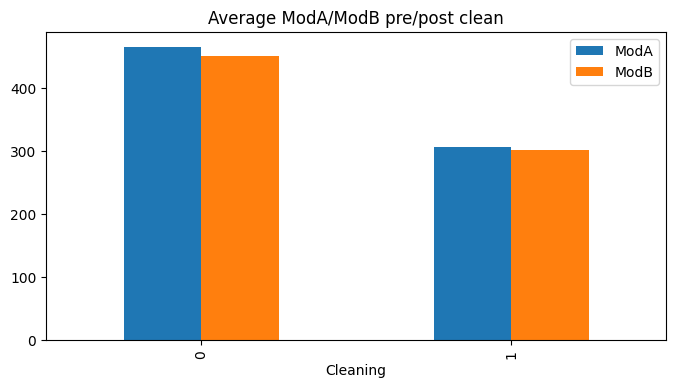

In [50]:
# Group by Cleaning flag and plot average ModA & ModB pre/post-clean. 

# Check if Cleaning exists
if 'Cleaning' in df.columns:
    # Group by cleaning flag and Plot as bar chart
    df.groupby('Cleaning')[['ModA','ModB']].mean().plot(kind='bar', figsize=(8,4))
    plt.title('Average ModA/ModB pre/post clean')
    plt.show()


e) Correlation & Relationship Analysis

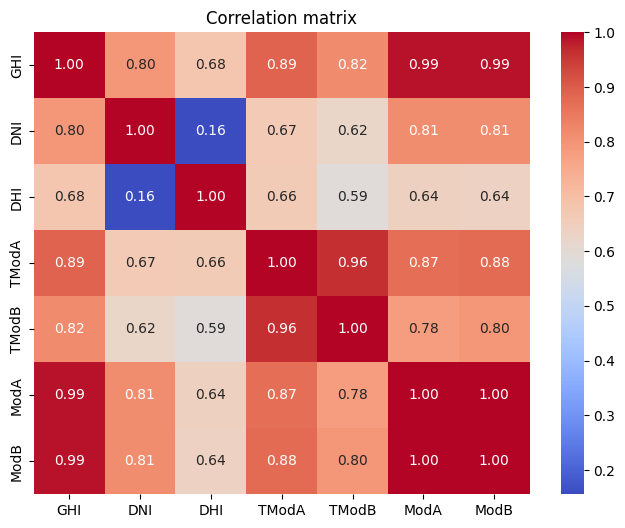

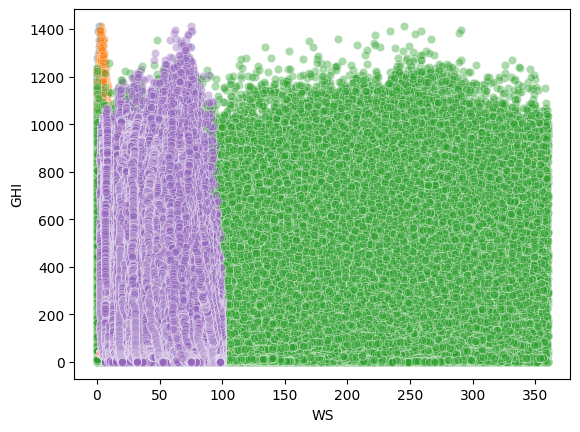

In [51]:
"""
Correlations reveal linear relationships between irradiance and module temperatures/outputs.

Heatmap and scatterplots show pairwise relationships.
"""
import seaborn as sns

# Heatmap
corr_cols = ['GHI','DNI','DHI','TModA','TModB','ModA','ModB']  
corr = df[corr_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Scatter plots for irradiance vs wind
sns.scatterplot(data=df, x='WS', y='GHI', alpha=0.4)
sns.scatterplot(data=df, x='WSgust', y='GHI', alpha=0.4)
sns.scatterplot(data=df, x='WD', y='GHI', alpha=0.4)

# Scatter plots for humidity vs temperature/irradiance
sns.scatterplot(data=df, x='RH', y='Tamb', alpha=0.4)
sns.scatterplot(data=df, x='RH', y='GHI', alpha=0.4)

plt.show()

f) Wind & Distribution Analysis

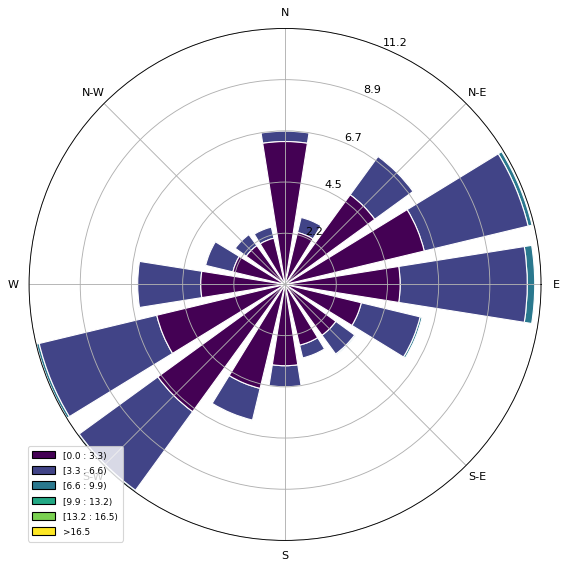

In [52]:
"""
Wind rose shows wind direction & speed distribution — useful to understand site conditions.

Histograms show distribution shapes (skewness), helpful for transformation decisions.
"""
# Wind rose
# pip install windrose
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df['WD'].dropna(), df['WS'].dropna(), normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()

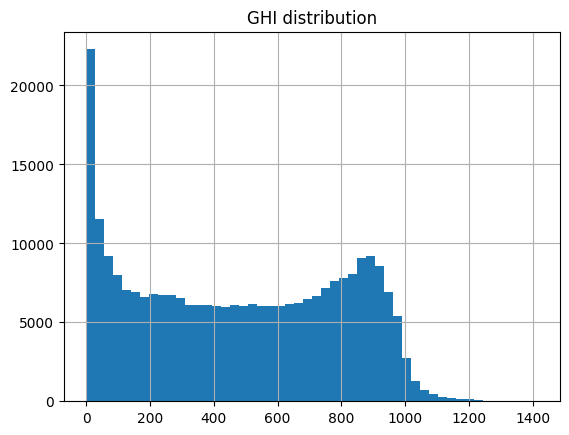

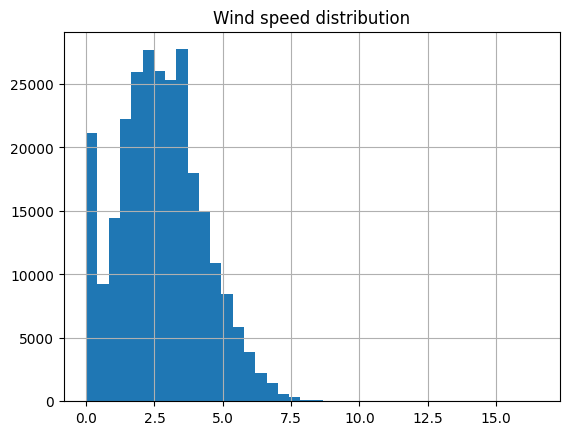

In [53]:
# Histogram for GHI
df['GHI'].hist(bins=50)
plt.title('GHI distribution')
plt.show()

# Histogram for WS
df['WS'].hist(bins=40)
plt.title('Wind speed distribution')
plt.show()


g) Temperature Analysis

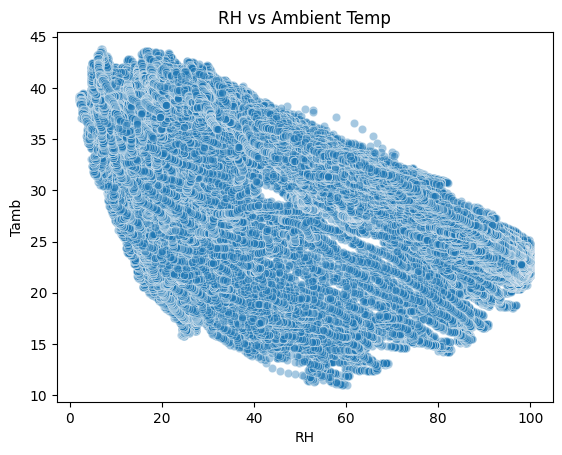

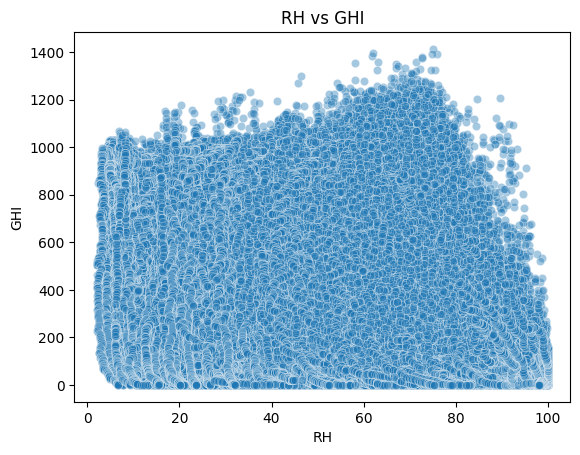

C:\Users\Admin\AppData\Local\Temp\ipykernel_9204\2188816867.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('RH_bin')[['Tamb','GHI']].mean()


,Tamb,GHI
RH_bin,,
"(2.002, 21.68]",33.494387,583.813041
"(21.68, 41.26]",32.906647,488.514591
"(41.26, 60.84]",32.400104,551.736238
"(60.84, 80.42]",29.244902,466.531066
"(80.42, 100.0]",24.624603,173.712379


In [54]:
"""
Analyze how RH affects temperature readings and radiation. High humidity may correlate with lower GHI due to cloudiness.
"""
sns.scatterplot(data=df, x='RH', y='Tamb', alpha=0.4)
plt.title('RH vs Ambient Temp')
plt.show()

sns.scatterplot(data=df, x='RH', y='GHI', alpha=0.4)
plt.title('RH vs GHI')
plt.show()

# Group by RH buckets and summarize
df['RH_bin'] = pd.cut(df['RH'], bins=5)
df.groupby('RH_bin')[['Tamb','GHI']].mean()


h) Bubble Chart

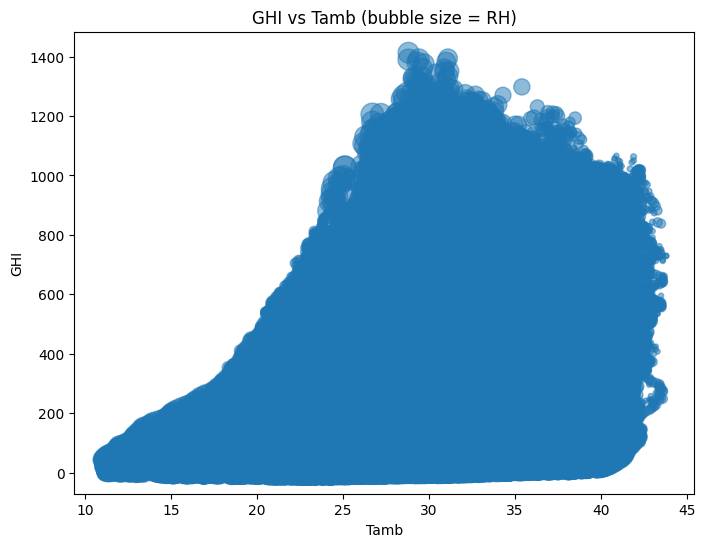

In [55]:
"""
Bubble chart adds a third variable (bubble size) to scatter relationships — here GHI vs Tamb with bubble = RH (or BP).
"""
plt.figure(figsize=(8,6))
sizes = (df['RH'] - df['RH'].min()).fillna(1)  # scale sizes
sizes = (sizes / sizes.max()) * 300           # scale to reasonable marker sizes
plt.scatter(df['Tamb'], df['GHI'], s=sizes, alpha=0.5)
plt.xlabel('Tamb')
plt.ylabel('GHI')
plt.title('GHI vs Tamb (bubble size = RH)')
plt.show()
